# Notebookの検索

## NBSearch拡張の有効化

NBSearch拡張は本イメージではデフォルトでは無効化されています。

NBextensionsタブで、 `NBSearch` 拡張のチェックを押して有効化してください。

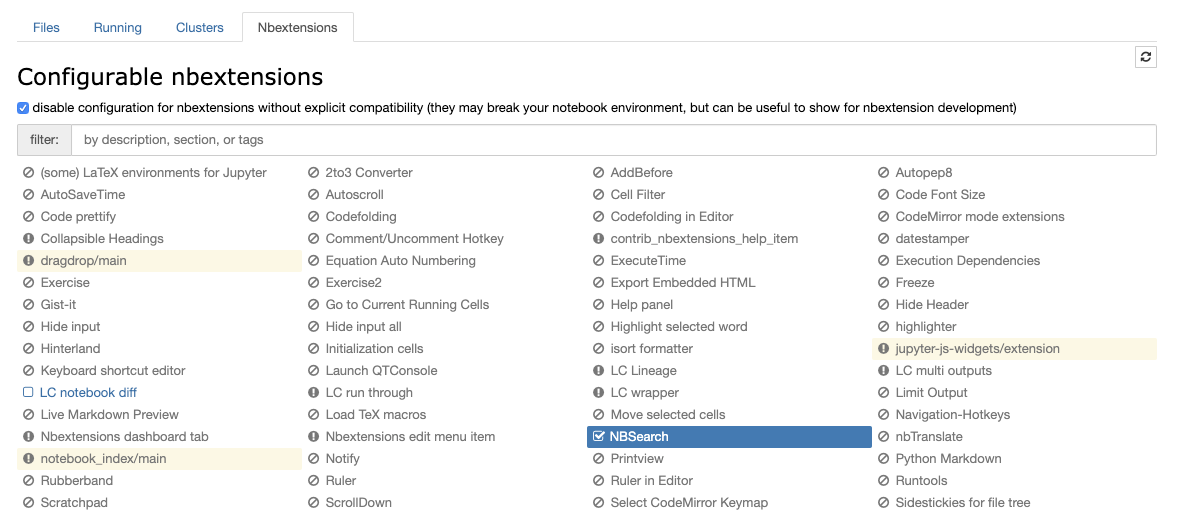


また、検索結果から `Notebookの比較` をおこないたい場合は、 `LC notebook diff` 拡張のチェックをして有効化してください。

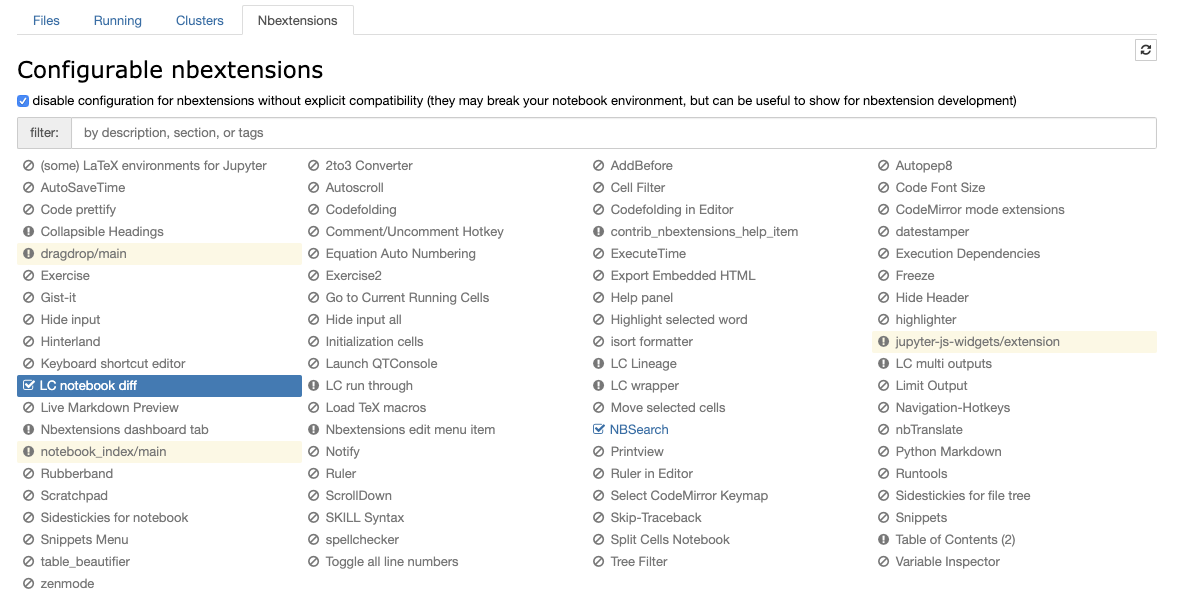

## NBSearchの使い方

*NBSearch拡張を有効化*後、ブラウザを再読み込みするとNBSearchタブが現れます。ここから、Notebookを検索することができます。

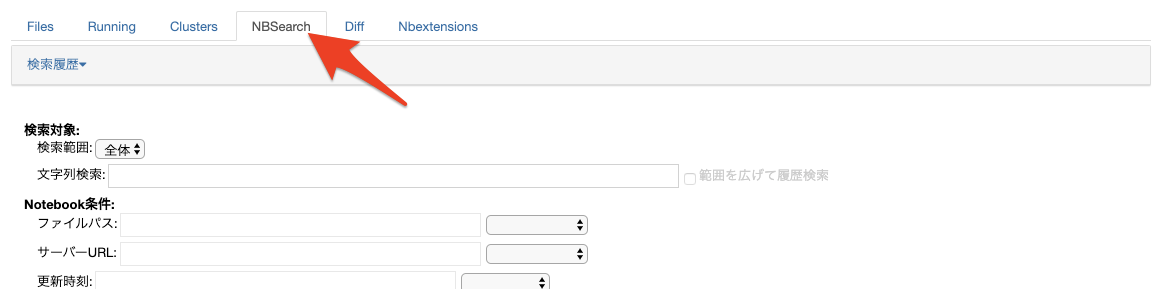

本イメージでは、デフォルトでは、Jupyterコンテナ内にMongoDBが動作します(データベースファイルは、 `~/.nbsearch/mongodb` に作成されます)。
ホームディレクトリ内で作成・変更したNotebookは自動的にNBSearchで検索可能になります。

### キーワードによる検索

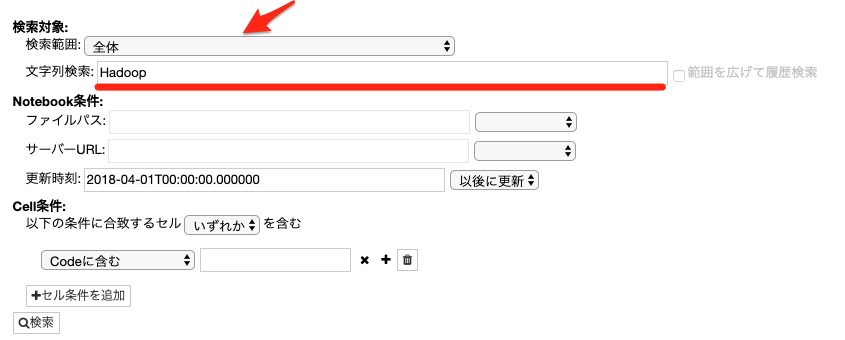

Notebook DBに保存されたNotebookを、文字列により検索します。文字列はCode Cell, Markdown Cell, Output, Pathを対象に検索されます。

キーワードによる検索は、後述する `NBSearchヒストリ` に対しては行えません。検索範囲を 全体 とした上で入力してください。

### Notebookの情報に基づく検索

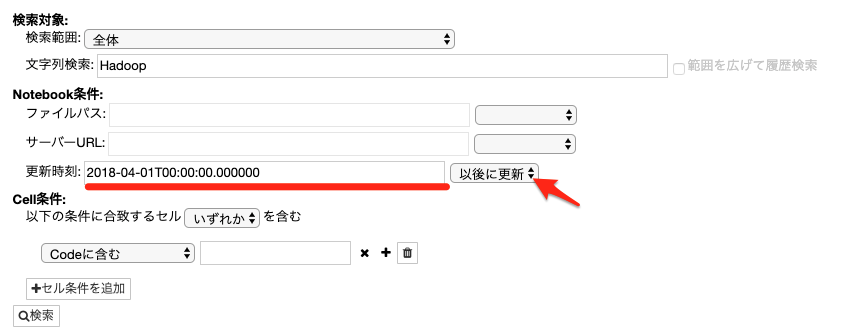

NotebookのファイルパスやサーバのURL, 更新時刻に対して検索することもできます。
まず、検索条件をドロップダウンから選択します。

* ファイルパス ... *一致* / *一致しない* / *含む* / *含まない*
* サーバーURL ... *一致* / *一致しない* / *含む* / *含まない*
* 更新時刻 ... *以前* / *以後* で選択、検索条件にANDで適用

その後、テキストフィールドに検索条件を入力して、 検索 を実施してください。
これらの条件は検索クエリに対してAND条件として適用されます。

### Cellの情報に基づく検索

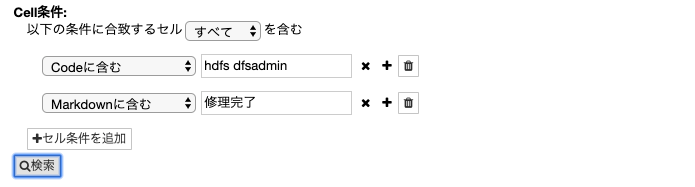

NotebookがどのようなCellを含んでいるかどうかを指定して検索することができます。
Cellに関する条件は複数設定することができます。横方向に+ボタンで追加すると、あるCellが満たすべき条件を追加することができます。また、縦方向に +セル条件を追加 を行うと、独立したCell条件を追加することができます。

* *すべて* / *いずれか* 含む ... セルの検索条件(N個)をAND/OR検索いずれで行うか。
* Cellの検索条件 ... *MEME完全一致* / *先行MEME完全一致* / *後続MEME完全一致* / *MEMEに含む* / *先行MEMEに含む* / *後続MEMEに含む* / *Codeに含む* / *Markdownに含む* / *Outputに含む* / *MEME一致しない* / *先行MEME一致しない* / *後続MEME一致しない* / *MEMEに含まない* / *先行MEMEに含まない* / *後続MEMEに含まない* / *Codeに含まない* / *Markdownに含まない* / *Outputに含まない*


### 検索結果の確認

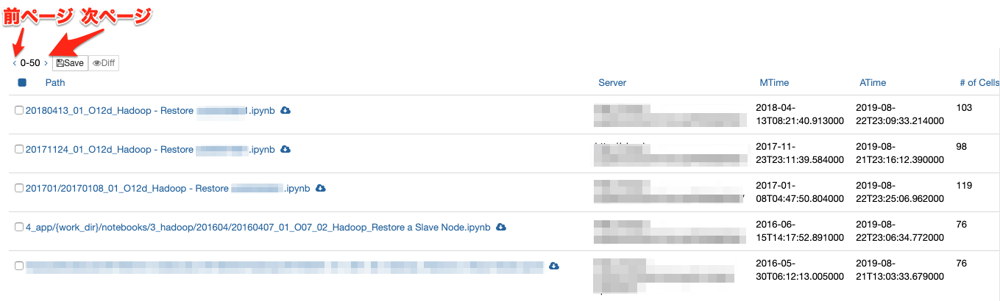

* ページの切り替え ... 検索結果が50を超える場合、 < > でページを切り替えることができます
* Save ... `NBSearchヒストリ` に検索結果を保存します。
* Diff ... 比較したいNotebookを検索結果からチェックボックスにより選択することで、 Notebook比較 を行うことができます。

#### Notebookのダウンロード

検索結果のパス名をクリックすると、Notebookを開くことができます。nbsearch-tmpというフォルダがNotebookフォルダ配下に作成され、そこに一時的にダウンロードされます。
ダウンロードボタン(雲↓)をクリックすると、現在のJupyterツリーで開いているフォルダ(Filesタブで確認できます)にNotebookをダウンロードし、開くことができます。

## NBSearchヒストリ

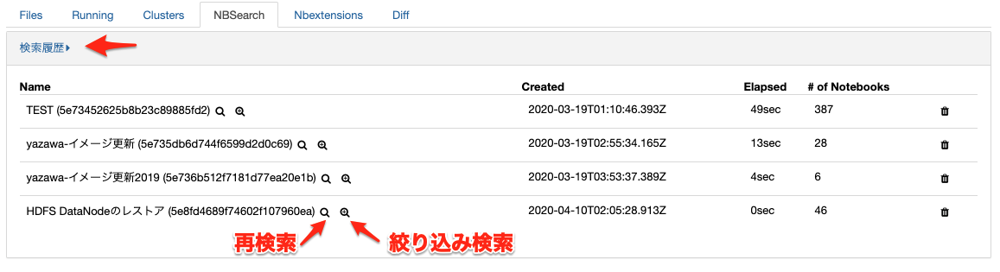

検索履歴バーをクリックすると、検索履歴の一覧を確認することができます。

* 再検索 ... ヒストリと同じ検索条件でNotebookを検索しなおします
* 絞り込み検索 ... ヒストリに保存されたNotebookに対して、検索を実施します